**Корректность проверена на Python 3.6:**
+ numpy 1.15.4
+ matplotlib 3.0.2
+ sklearn 0.20.2

Видео к уроку: https://www.coursera.org/learn/supervised-learning/lecture/MvjdW/linieinyie-modieli-sklearn-linear-model-rieghriessiia

# Sklearn

## sklearn.linear_model

In [1]:
from matplotlib.colors import ListedColormap
from sklearn import model_selection, datasets, linear_model, metrics

import numpy as np

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Линейная регрессия

#### Генерация данных

В данном случае мы будем строить dataset с двумя признаками. Пускай один из них будет информативным, другой будет избыточным. Также добавим некоторый шум. Еще один параметр, который мы укажем, это параметр `coef = True`. Он нужен для того, чтобы мы могли с вами посмотреть на уравнение функции, которую мы приближаем. То есть мы попросим метод вернуть нам не только данные, но и само уравнение.

In [11]:
data, target, coef = datasets.make_regression(n_features = 2, n_informative = 1, n_targets = 1, 
                                              noise = 5., coef = True, random_state = 2)

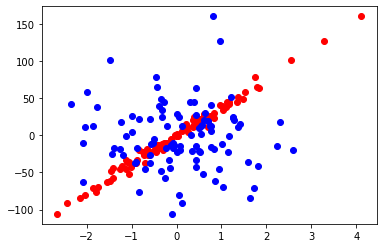

In [12]:
pylab.scatter(data[:,0], target, color = 'r')
pylab.scatter(data[:,1], target, color = 'b')

In [15]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(data, target,  
                                                                                     test_size = 0.3)

#### LinearRegression

мы ожидаем больший коэффициент (абсолютную величину) перед информативным признаком и меньший коэффициент по абсолютной величине перед избыточным признаком. 

In [16]:
linear_regressor = linear_model.LinearRegression()
linear_regressor.fit(train_data, train_labels)
predictions = linear_regressor.predict(test_data)

In [17]:
print(test_labels)

[ 29.8208999   28.15553021  -4.38652971  58.26281761  13.02656201
 -16.65927231 -19.16792315  11.96165156 -35.32062686 -37.31870104
  12.47089016  19.66406455 -22.33224966 -76.75213382 -52.37232463
 -15.01435792  20.87713077  17.64282734   5.86887774  25.24428409
  11.74073026 -80.80239408  64.19559505 -17.27897399  22.2276832
 -12.98848753 -16.79027112 101.14760598  39.70663436  12.42286854]


In [18]:
print(predictions)

[ 31.87248573  22.57229433  -5.14881887  55.90993746  18.76023861
 -15.0366541   -9.22765881  14.36677675 -40.44713824 -35.18705996
  20.3799731   26.87525862 -28.71043142 -69.31440388 -40.01291722
  -8.25551529  13.98760373  22.99264105   5.21815325  14.45763123
  15.16607863 -77.7968099   69.91146184 -13.41200484  17.92373845
 -16.36605701 -14.64836543  95.14877857  37.3414249    7.12449055]


In [19]:
metrics.mean_absolute_error(test_labels, predictions)

4.964686264568325

In [20]:
linear_scoring = model_selection.cross_val_score(linear_regressor, data, target, scoring = 'neg_mean_absolute_error', 
                                                  cv = 10)
print('mean: {}, std: {}'.format(linear_scoring.mean(), linear_scoring.std()))

mean: -4.070071498779698, std: 1.073710449289019


Мы видим, что в среднем наша ошибка равна 4 с отклонением 1. Единственное, что нас здесь должно смутить, это знак «минус» перед средним. Ну, действительно, мы оцениваем метрику «среднее абсолютное отклонение», поэтому она должна быть неотрицательной. А здесь мы видим минус, потому что функция cross_val_score часто используется для подбора параметров алгоритма. В данном случае в качества scoring мы передаем метрику, которая не растет, когда модель становится лучше, а которая уменьшается, когда модель становится лучше. А так как при подборе параметров часто используется максимизация нашей метрики, то нам просто удобно иногда умножить нашу метрику на (−1) и дальше ее точно так же максимизировать.


Чтобы от такого избавиться, мы можем создать свой собственный scorer. Давайте это и сделаем, создадим scorer с помощью функции make_scorer и скажем, что для нашей метрики greater_is_better, то есть значение, когда наша метрика растет, это лучше. Естественно, это не так, но просто с помощью такого параметра мы с вами избавимся от искусственного умножения на (−1).

In [23]:
scorer = metrics.make_scorer(metrics.mean_absolute_error, greater_is_better = True)

In [24]:
linear_scoring = model_selection.cross_val_score(linear_regressor, data, target, scoring=scorer, 
                                                  cv = 10)
print('mean: {}, std: {}'.format(linear_scoring.mean(), linear_scoring.std()))

mean: 4.070071498779698, std: 1.073710449289019


In [25]:
coef

array([38.07925837,  0.        ])

In [26]:
linear_regressor.coef_

array([38.00850429,  1.01510615])

In [27]:
# в лекции не указано, что в уравнении обученной модели также участвует свободный член
linear_regressor.intercept_

-0.2941368246581315

In [30]:
# Исходное уравнение, которое участвовало в генерации данных
print("y = {:.2f}*x1 + {:.2f}*x2".format(coef[0], coef[1]))

y = 38.08*x1 + 0.00*x2


In [31]:
# Уравнение, полученное с помощью регрессии
print("y = {:.2f}*x1 + {:.2f}*x2 + {:.2f}".format(linear_regressor.coef_[0], 
                                                  linear_regressor.coef_[1], 
                                                  linear_regressor.intercept_))

y = 38.01*x1 + 1.02*x2 + -0.29


#### Lasso

Теперь давайте попробуем решить ту же самую задачу с помощью другого метода регрессии. Мы рассмотрим лассо-регрессию — регрессию с использованием регуляризации lasso или регуляризации L1. 

In [33]:
lasso_regressor = linear_model.Lasso(random_state = 3)
lasso_regressor.fit(train_data, train_labels)
lasso_predictions = lasso_regressor.predict(test_data)

In [34]:
lasso_scoring = model_selection.cross_val_score(lasso_regressor, data, target, scoring = scorer, cv = 10)
print('mean: {}, std: {}'.format(lasso_scoring.mean(), lasso_scoring.std()))

mean: 4.154478246666397, std: 1.0170354384993354


In [35]:
print(lasso_regressor.coef_)

[37.26339289  0.        ]


In [36]:
print("y = {:.2f}*x1 + {:.2f}*x2".format(coef[0], coef[1]))

y = 38.08*x1 + 0.00*x2


In [37]:
print("y = {:.2f}*x1 + {:.2f}*x2".format(lasso_regressor.coef_[0], lasso_regressor.coef_[1]))

y = 37.26*x1 + 0.00*x2


Если в вашей задаче много избыточных признаков и вы хотите заняться отбором признаков, то есть вы хотите получить перед ними не просто маленькие веса, а действительно получить нули и отфильтровать такие признаки, то лассо-регуляризация очень хорошо подходит для этой задачи.

Тут можно почитать **про отличие L1 и L2-регуляризации**: https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c

Также **материал в лекции**: https://www.coursera.org/learn/supervised-learning/lecture/k2VxN?t=6